### Alpha-Line Interpolation Between Robust/Feeble Model

Sept 24 2023
TJ Kim

##### Summary
Load model trained with federated adversarial training (FAT, high robustness against adversarial attacks) and FedAvg (low robustness). We make linear combinations of parameters of models and see if the robustness gradually changes as we sweep between FAT and FedAvg models.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 153.35it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:14<00:00,  5.47it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


In [4]:
# Linear extrapolation of model for each layer
stepsize_alpha = 0.05
alpha_set = np.arange(0,1+stepsize_alpha,stepsize_alpha)

models_test = []

params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()


for (a) in alpha_set:
    # first make the model with empty weights
    new_model = copy.deepcopy(model_FAT)
    new_model.eval()
    new_weight_dict = copy.deepcopy(params_FAT)
    for key in params_FAT:
        new_weight_dict[key] = a*params_FedAvg[key] + (1-a)*params_FAT[key] 
    new_model.load_state_dict(new_weight_dict)
    models_test += [new_model]


In [5]:
# Perform transfer attack from one client to another and record stats
# models_test = [model_Fedavg, model_FAT]

# Run Measurements for both targetted and untargeted analysis
victim_idxs = range(len(models_test))
logs_adv = generate_logs_adv(len(models_test))
custom_batch_size = 500
eps = 3

dataloader = load_client_data(clients = clients, c_id = 0, mode = 'all') # or test/train
cross_attack(logs_adv, victim_idxs, dataloader, models_test, custom_batch_size, eps)

	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20


In [6]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
            'adv_similarities_untarget','adv_target','adv_miss']

adv_miss = get_metric_list("adv_miss", logs_adv, victim_idxs)
acc = get_metric_list("orig_acc_transfers", logs_adv, victim_idxs)

# Print along diagonal and plot "robustness against white-box attacks (self)"
alpha_list = alpha_set.tolist()
adv_list = []
acc_list = []
for i in range(adv_miss.shape[0]):
    adv_list += [adv_miss[i,i]]
    acc_list += [acc[i,i]]



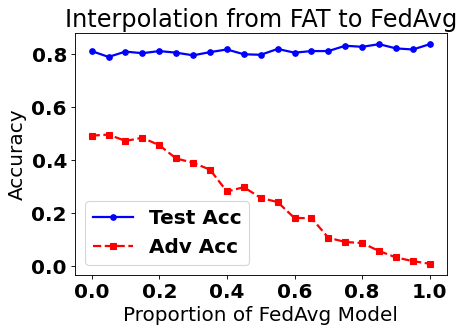

In [18]:
import matplotlib
from matplotlib import pyplot as plt

x = alpha_list
y1 = acc_list
y2 = adv_list

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Create a figure and axis
# fig, ax = plt.subplots()

# Plot the first line (y1)
plt.plot(x, y1, label='Test Acc', color='b', linewidth=2, linestyle='-', marker='o', markersize=5)

# Plot the second line (y2)
plt.plot(x, y2, label='Adv Acc', color='r', linewidth=2, linestyle='--', marker='s', markersize=5)

# Set plot title and labels
plt.title('Interpolation from FAT to FedAvg')
plt.xlabel('Proportion of FedAvg Model')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Customize the grid
# ax.grid(True, linestyle='--', alpha=0.7)

# Customize the plot style
# plt.style.use('seaborn-darkgrid')

# Show the plot
plt.show()